In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.9.1


In [2]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Cloning https://github.com/tensorflow/docs to /private/var/folders/x6/lvkjlh4x45bdhl62l88rhwzm0000gn/T/pip-req-build-eacq1xub
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/x6/lvkjlh4x45bdhl62l88rhwzm0000gn/T/pip-req-build-eacq1xub
  Resolved https://github.com/tensorflow/docs to commit 8d7222b112c4b38af84f9000dfc047b7cdcbb6ff
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.6/197.6 kB 4.0 MB/s eta 0:00:0000:01
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=176169 sha256=17bbc4c6a91504076f5df179bcb6ff5933086ad5c8e49baf45b337afdb5b0b13
  Stored in directory: /private/var/folders/

In [3]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

In [5]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [6]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 [==============================] - 216s 0us/step


In [7]:
Features = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(Features+1), compression_type="GZIP")

2022-07-21 11:37:55.556893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
def packRow(*row):
    label=row[0]
    features = tf.stack(row[1:],1)
    return features, label

In [11]:
packed_ds = ds.batch(10000).map(packRow).unbatch()

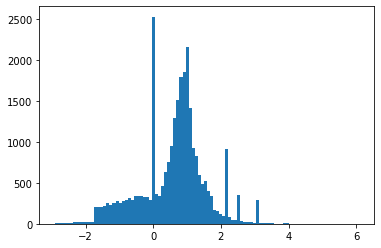

In [14]:
for f, l in packed_ds.batch(1000).take(1):

    plt.hist(f.numpy().flatten(), bins=100)

In [15]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [16]:
valid_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [18]:
valid_ds = valid_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [32]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [58]:
def get_callbacks(name):
    return [ 
            tfdocs.modeling.EpochDots(),
            tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
            tf.keras.callbacks.TensorBoard(logdir/name)
           ]

In [59]:
def compileAndFit(model, name, optimizer=None, maxEpochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[
                      tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'), 'accuracy'
                  ])
    model.summary()
    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=maxEpochs,
        validation_data=valid_ds,
        callbacks=get_callbacks(name),
        verbose=0)
    return history

In [60]:
tinyModel = tf.keras.Sequential([
    layers.Dense(16,activation='elu', input_shape=(Features,)),
    layers.Dense(1)])

In [61]:
sizeHistories={}
sizeHistories['Tiny'] = compileAndFit(tinyModel, 'sizes/Tiny')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 16)                464       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4942,  binary_crossentropy:0.7667,  loss:0.7667,  val_accuracy:0.4990,  val_binary_crossentropy:0.7455,  val_loss:0.7455,  
....................................................................................................
Epoch: 100, accuracy:0.5981,  binary_crossentropy:0.6255,  loss:0.6255,  val_accuracy:0.6000,  val_binary_crossentropy:0.6256,  val_loss:0.6256,  
..........................................................

In [62]:
print(sizeHistories['Tiny'].history.keys())


dict_keys(['loss', 'binary_crossentropy', 'accuracy', 'val_loss', 'val_binary_crossentropy', 'val_accuracy'])


(0.5, 0.7)

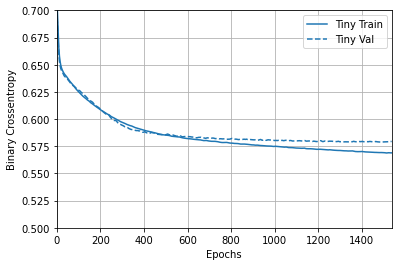

In [63]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(sizeHistories)
plt.ylim([0.5, 0.7])

In [64]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(Features,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

sizeHistories['Small'] = compileAndFit(small_model, 'sizes/Small')

In [67]:
med_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(Features,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

sizeHistories['Medium'] = compileAndFit(med_model, 'sizes/Med')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 64)                1856      
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4889,  binary_crossentropy:0.6976,  loss:0.6976,  val_accuracy:0.5150,  val_binary_crossentropy:0.6824,  val_loss:0.6824,  
....................................

In [70]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(Features,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 512)               14848     
                                                                 
 dense_29 (Dense)            (None, 512)               262656    
                                                                 
 dense_30 (Dense)            (None, 512)               262656    
                                                                 
 dense_31 (Dense)            (None, 512)               262656    
                                                                 
 dense_32 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5046,  binary_crossentrop

NameError: name 'size_histories' is not defined

In [71]:
sizeHistories['large'] = compileAndFit(large_model, "sizes/large")

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 512)               14848     
                                                                 
 dense_29 (Dense)            (None, 512)               262656    
                                                                 
 dense_30 (Dense)            (None, 512)               262656    
                                                                 
 dense_31 (Dense)            (None, 512)               262656    
                                                                 
 dense_32 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.8830,  binary_crossentrop

(0.5, 0.7)

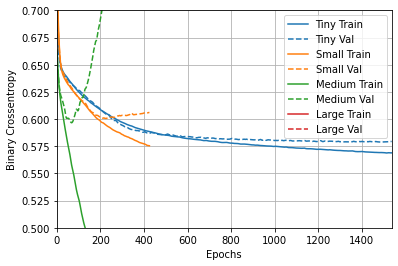

In [74]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(sizeHistories)
plt.ylim([0.5, 0.7])

Text(0.5, 0, 'Epochs [Log Scale]')

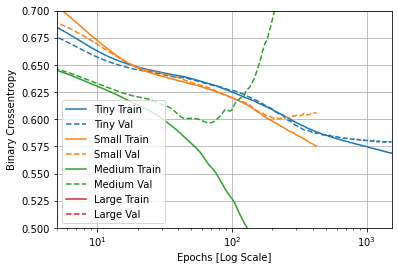

In [75]:
plotter.plot(sizeHistories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [76]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

In [77]:
shutil.rmtree(logdir/'regulizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/var/folders/x6/lvkjlh4x45bdhl62l88rhwzm0000gn/T/tmplx4hl1b5/tensorboard_logs/regularizers/Tiny')

In [78]:
regularizerHist={}
regularizerHist['Tiny'] = sizeHistories['Tiny']

In [94]:
l2Model = tf.keras.Sequential([
        layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001),input_shape=(Features,)),
        layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(1)
])
regularizerHist['l2'] = compileAndFit(l2Model, 'regularlizers/l2')

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 512)               14848     
                                                                 
 dense_54 (Dense)            (None, 512)               262656    
                                                                 
 dense_55 (Dense)            (None, 512)               262656    
                                                                 
 dense_56 (Dense)            (None, 512)               262656    
                                                                 
 dense_57 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5032,  binary_crossentrop

In [93]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(Features,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regul['dropout'] = compileAndFit(dropout_model, "regularizers/dropout")

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_49 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_50 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_51 (Dense)            (None, 512)             

(0.0, 800.0)

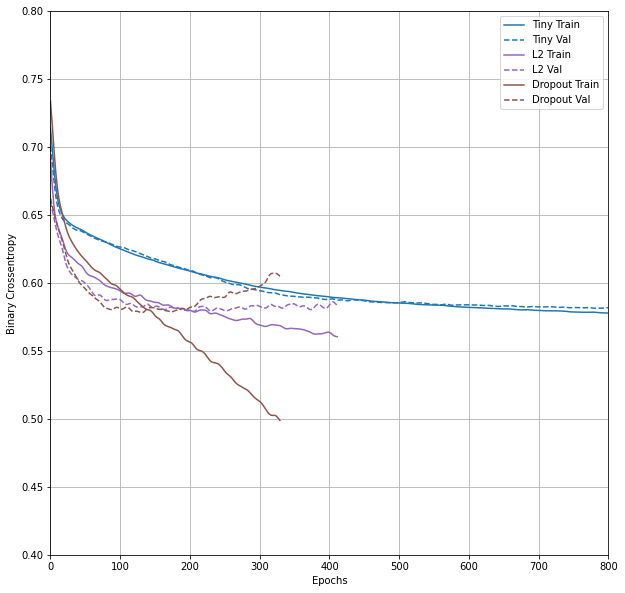

In [99]:
plt.figure(figsize=(10,10))

plotter.plot(regularizerHist)
plt.ylim([0.4, .8])
plt.xlim([0, 800])

In [101]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(Features,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizerHist['combined'] = compileAndFit(combined_model, "regularizers/combined")

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 512)               14848     
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_64 (Dense)            (None, 512)               262656    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_65 (Dense)            (None, 512)               262656    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_66 (Dense)            (None, 512)             

(0.0, 900.0)

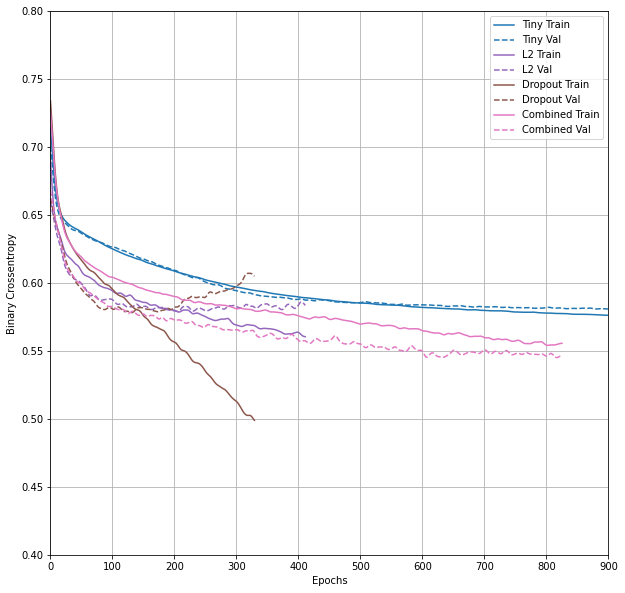

In [102]:
plt.figure(figsize=(10,10))

plotter.plot(regularizerHist)
plt.ylim([0.4, .8])
plt.xlim([0, 900])